# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.590398,False,-0.142035
1,-0.439374,False,-0.072774
2,-1.996601,False,0.140430
3,-1.788554,False,-0.901035
4,-2.346612,False,-0.805685
...,...,...,...
995,-1.102293,False,0.888031
996,-2.298781,False,-0.423890
997,0.350439,False,0.960244
998,-0.204328,False,1.857682


<Axes: xlabel='v0'>

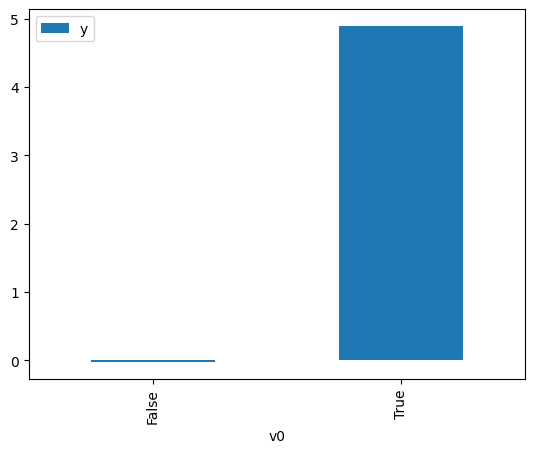

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

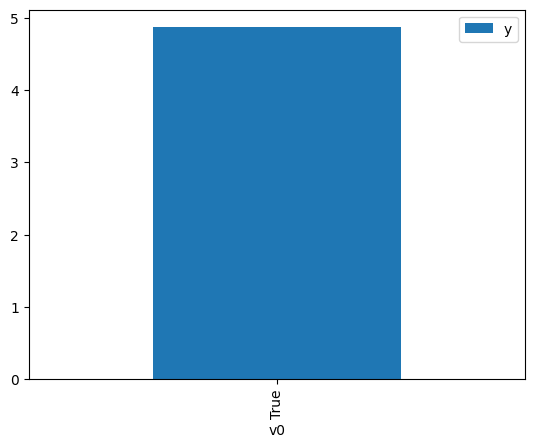

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.766497,False,-0.786821,0.816266,1.225090
1,-0.982490,False,-0.821939,0.867710,1.152459
2,-1.560978,False,-0.083517,0.949036,1.053701
3,-0.222496,False,-0.131628,0.624804,1.600502
4,-0.835693,False,0.531195,0.834252,1.198678
...,...,...,...,...,...
995,-0.854320,False,-0.912382,0.838846,1.192114
996,-0.763953,False,-0.381300,0.815577,1.226126
997,-0.592933,False,-0.056549,0.764620,1.307839
998,-2.367274,False,-0.957950,0.987614,1.012541


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.216325,True,4.569764,0.569926,1.754612
1,0.030281,True,5.406192,0.486495,2.055519
2,-1.046454,True,4.364662,0.119598,8.361311
3,1.613805,True,6.215746,0.942801,1.060670
4,1.360722,True,5.098013,0.912600,1.095770
...,...,...,...,...,...
995,-0.676737,True,4.341361,0.209268,4.778572
996,1.819160,True,5.889055,0.959795,1.041889
997,0.214163,True,6.186792,0.568970,1.757561
998,0.051968,True,4.581237,0.496271,2.015026


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                              4309.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):                        0.00
Time:                        18:42:42   Log-Likelihood:                         -1385.0
No. Observations:                1000   AIC:                                      2774.
Df Residuals:                     998   BIC:                                      2784.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2065      0.026      7.863      0.000       0.155       0.258
x2             4.9799      0.055     91.099      0.000       4.873       5.087
==============================================================================
Omnibus:                        2.207   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.332   Jarque-Bera (JB):                2.064
Skew:                           0.098   Prob(JB):                        0.356
Kurtosis:                       3.104   Cond. No.                         2.10
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""